In [4]:
!pip install transformers

  Using cached transformers-4.53.0-py3-none-any.whl.metadata (39 kB)
  Using cached huggingface_hub-0.33.1-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.21.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached hf_xet-1.1.5-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (879 bytes)
Using cached transformers-4.53.0-py3-none-any.whl (10.8 MB)
Using cached huggingface_hub-0.33.1-py3-none-any.whl (515 kB)
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
Using cached tokenizers-0.21.2-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
Using cached hf_xet-1.1.5-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)


/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3  |  loss: 0.9265
Epoch 2/3  |  loss: 0.5679
Epoch 3/3  |  loss: 0.4658

 Classification Report (RoBERTa 5-class):

                     precision    recall  f1-score   support

    academic_stress     0.9799    0.8330    0.9005       527
 existential_crisis     0.0000    0.0000    0.0000        18
            neutral     0.7405    0.8562    0.7942       480
relationship_issues     0.7034    0.7385    0.7205       501
   social_isolation     0.6667    0.5000    0.5714        12

           accuracy                         0.7971      1538
          macro avg     0.6181    0.5856    0.5973      1538
       weighted avg     0.8012    0.7971    0.7956      1538



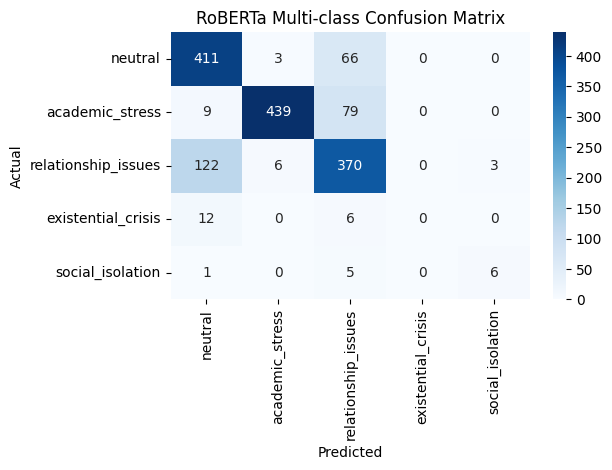


✓ Fine-tuned model saved to  Project/Models/RoBERTa_Multiclass


In [5]:
import os, gc, warnings, torch, numpy as np, pandas as pd, seaborn as sns
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW                     # ← changed line
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
warnings.filterwarnings("ignore")

#Config / Hyper-params
MODEL_NAME   = "roberta-base"
MAX_LEN      = 128
BATCH_SIZE   = 16
EPOCHS       = 3
LR           = 2e-5
OUTPUT_DIR   = "Project/Models/RoBERTa_Multiclass"
os.makedirs(OUTPUT_DIR, exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AMP    = torch.cuda.is_available()                      # mixed precision

#1) Load data & map labels
CLASSES = [
    "neutral",
    "academic_stress",
    "relationship_issues",
    "existential_crisis",
    "social_isolation",
]
str2id = {lbl: i for i, lbl in enumerate(CLASSES)}
id2str = {i: lbl for lbl, i in str2id.items()}

df = pd.read_csv("Project/reddit_labeled.csv")
df = df[df["label"].isin(CLASSES)]
df["label_id"] = df["label"].map(str2id)

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"].astype(str),
    df["label_id"],
    test_size=0.2,
    stratify=df["label_id"],
    random_state=42
)

#Dataset
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

class RedditDS(Dataset):
    def __init__(self, texts, labels):
        self.texts  = texts.tolist()
        self.labels = labels.tolist()
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        enc = tok(self.texts[idx],
                  max_length=MAX_LEN,
                  padding="max_length",
                  truncation=True,
                  return_tensors="pt")
        return {
            "input_ids"     : enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels"        : torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_loader = DataLoader(RedditDS(X_train, y_train),
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          pin_memory=True)
test_loader  = DataLoader(RedditDS(X_test,  y_test ),
                          batch_size=BATCH_SIZE,
                          pin_memory=True)

#Model, optimiser, scheduler
model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=len(CLASSES)
        ).to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LR)
steps_per_epoch = len(train_loader)
scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=int(0.1 * steps_per_epoch * EPOCHS),
                num_training_steps=steps_per_epoch * EPOCHS
            )

scaler = torch.cuda.amp.GradScaler(enabled=AMP)
loss_fn = nn.CrossEntropyLoss()

#Training loop
model.train()
for epoch in range(EPOCHS):
    running = 0
    for batch in train_loader:
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=AMP):
            out   = model(input_ids=batch["input_ids"],
                          attention_mask=batch["attention_mask"],
                          labels=batch["labels"])
            loss  = out.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}  |  loss: {running/len(train_loader):.4f}")

#Evaluation
model.eval(); preds, trues = [], []
with torch.no_grad():
    for batch in test_loader:
        batch = {k:v.to(DEVICE) for k,v in batch.items()}
        logits = model(input_ids=batch["input_ids"],
                       attention_mask=batch["attention_mask"]).logits
        preds.extend(torch.argmax(logits,1).cpu().tolist())
        trues.extend(batch["labels"].cpu().tolist())

print("\n Classification Report (RoBERTa 5-class):\n")
print(classification_report([id2str[i] for i in trues],
                            [id2str[i] for i in preds],
                            digits=4))

cm = confusion_matrix(trues, preds, labels=list(range(len(CLASSES))))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("RoBERTa Multi-class Confusion Matrix")
plt.tight_layout(); plt.show()

#Save
model.save_pretrained(OUTPUT_DIR)
tok.save_pretrained(OUTPUT_DIR)
print(f"\n Fine-tuned model saved to  {OUTPUT_DIR}")

In [13]:
#Inference helper ──────────────────────────────────────
def predict(text: str):
    model.eval()
    enc = tok(text, return_tensors="pt",
              truncation=True, padding=True,
              max_length=MAX_LEN).to(DEVICE)
    with torch.no_grad():
        logits = model(**enc).logits
        idx    = int(torch.argmax(logits,1))
        prob   = torch.softmax(logits,1)[0,idx].item()
    return id2str[idx], prob
# Example
print("\nTest run:")
txt = "No matter what you do, you will end up failing."
lbl, p = predict(txt)
print(f" “{txt[:60]}”  →  {lbl} ")


Test run:
 “No matter what you do, you will end up failing.”  →  academic_stress 


In [6]:
#!pip install torch transformers[torch] scikit-learn seaborn matplotlib

In [4]:
#!pip uninstall transformers -y

In [3]:
#!pip install transformers==4.39.3

In [5]:
#!pip install --upgrade accelerate